# 1. Setup

## 1.A Summary

### <span style="color: #e74c3c;">**k-Nearest Neighbours Implementation Summary**</span>

This notebook implements **k-Nearest Neighbours (k-NN)** classification to predict student withdrawal risk using the preprocessed student dataset.

### <span style="color: #2E86AB;">**1. Algorithm Overview**</span>

**k-Nearest Neighbours** is a **non-parametric, instance-based learning algorithm** that makes predictions by:
- Finding the k closest data points to a new instance
- Using majority voting amongst these neighbours to determine classification
- Making no assumptions about the underlying data distribution

**Key characteristics:**
- **Lazy learning**: No explicit training phase - stores all data points
- **Distance-based**: Uses similarity measures (typically Euclidean distance)
- **Local decision boundaries**: Adapts to local patterns in the data

### <span style="color: #2E86AB;">**2. Binary Classification Setup**</span>

**Target transformation**: Combined "Graduate" and "Enrolled" into "Continuation" (1), with "Dropout" as "Withdrawn" (0), creating a balanced 68:32 class distribution suitable for k-NN's majority voting mechanism.

**Dataset**: 4,424 students with preprocessed features ready for distance-based classification.

### <span style="color: #2E86AB;">**3. Preprocessing Requirements**</span>

**Essential for k-NN performance:**
- **Feature scaling**: StandardScaler applied to prevent features with larger ranges from dominating distance calculations
- **One-hot encoding**: Categorical features converted to binary dummy variables
- **Feature selection**: Remove redundant and uninformative features identified in earlier analysis

### <span style="color: #2E86AB;">**4. Model Configuration**</span>

**Hyperparameter tuning** focuses on:
- **k value**: Number of neighbours to consider (typically odd numbers to avoid ties)
- **Distance metric**: Euclidean distance for continuous features
- **Weighting scheme**: Uniform vs distance-weighted voting

### <span style="color: #e74c3c;">**Expected Outcomes**</span>

This implementation will evaluate k-NN's effectiveness for student dropout prediction, comparing performance against logistic regression whilst addressing the algorithm's sensitivity to feature scaling and dimensionality.

## 1.B Libraries Import

In [106]:
# Project-specific utilities (keep only if used elsewhere)
from tools import Tools  

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)


## 1.C Invoke Classes

In [107]:
tools = Tools()

## 1.D Load Configuration

In [108]:
config = tools.load_toml_file("config.toml")
tools.print_message('success', 'Loaded configuration', format_dict={'number of keys': len(config)})

>>> [12:30:18] SUCCESS!: Loaded configuration NUMBER OF KEYS: 2

## 1.E Load the dataset

In [109]:
# Open dataset
# Realinho, V., Martins, M.V., Machado, J. and Baptista, L.M.T., 2021. Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C5MC89 [Accessed 31 May 2025].
df_dataset = tools.load_dataset(file_name='dataset_raw.csv')
df_dataset.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 1.F Apply Target Binary Transformation

In [110]:
# Add a new target column with renamed values for one vs rest classification
df_dataset['target_binary'] = df_dataset['target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})
df_dataset['target_binary'].value_counts()

target_binary
1    3003
0    1421
Name: count, dtype: int64

## 1.G Data Shape Check

In [111]:
shape = df_dataset.shape
tools.print_message('success', 'Dataset loaded', format_dict={'rows': shape[0], 'columns': shape[1]})

>>> [12:30:18] SUCCESS!: Dataset loaded ROWS: 4424, COLUMNS: 38

# 2. Feature Selection

## 2.A Summary

### <span style="color: #e74c3c;">**Feature Selection for k-Nearest Neighbours**</span>

This analysis reduced the dataset from 36 original features to 10 carefully selected features optimised for k-NN performance. The selection process addressed key challenges including data leakage, multicollinearity, and the curse of dimensionality.

### <span style="color: #2E86AB;">**1. Data Leakage Prevention**</span>

**Data leakage** occurs when we accidentally include information that wouldn't be available when making real predictions. In our student withdrawal dataset, second semester data creates severe leakage issues.

**The Problem:**
- Students who withdraw during first semester have **zero values** for all second semester metrics
- These zeros perfectly identify withdrawn students - but only **after** withdrawal has occurred
- Using 2nd semester features gives artificially high accuracy but useless real-world predictions

**Solution Applied:**
- **Removed ALL second semester features**: grades, credited units, enrolled units, approved units, evaluations
- **Kept first semester features**: These represent genuine early warning indicators available during the semester
- **Focus on early intervention**: The model can now predict withdrawals using information available **before** students drop out

### <span style="color: #2E86AB;">**2. Multicollinearity Resolution**</span>

**Multicollinearity** occurs when features provide nearly identical information, measured by **Variance Inflation Factor (VIF)**. High VIF values harm k-NN performance by:
- Creating redundant dimensions in distance calculations
- Amplifying noise and reducing accuracy
- Making feature scaling less effective

**Problematic Features Removed:**
- `curricular_units_1st_sem_enrolled` (VIF: 23.49)
- `curricular_units_1st_sem_credited` (VIF: 15.57)  
- `curricular_units_1st_sem_approved` (VIF: 12.63)

**Kept:** `curricular_units_1st_sem_grade` (VIF: 4.98) - represents actual academic performance without multicollinearity issues.

### <span style="color: #2E86AB;">**3. High Cardinality Feature Engineering**</span>

**High cardinality features** (many categories) create severe problems for k-NN. Two different encoding strategies were applied:

### <span style="color: #2E86AB;">**Parental Background - Binary Grouping:**</span>
- Parents' **qualifications** had **29 categories each**
- Parents' **occupations** had **46 categories each**
- After one-hot encoding, this would create **150 new binary features** (29+29+46+46)

**Solution Applied:**
```python
# Reduced 4 high-cardinality features to 2 meaningful binary indicators:
parental_higher_education          # Combines 58 education categories
parental_professional_occupation   # Combines 92 occupation categories
```

### <span style="color: #2E86AB;">**Academic Context - Withdrawal Rate Encoding:**</span>
- `course`: 17 different programmes of study
- `application_mode`: 18 different admission routes

**Solution Applied:**
```python
# Target encoding using withdrawal rates for each category:
course_withdrawal_rate              # Each course gets its historical withdrawal rate
application_mode_withdrawal_rate    # Each application route gets its withdrawal rate
```

**Benefits of Withdrawal Rate Encoding:**
- **Reduces dimensionality**: 17 course categories → 1 continuous feature
- **Preserves predictive power**: Directly captures risk level of each category
- **Interpretable results**: Higher values = higher risk groups
- **k-NN friendly**: Creates meaningful distance measurements between similar risk levels

**Overall Benefits:**
- Captures meaningful background and context information
- Reduces dimensionality from 150+ to 4 features
- Maintains predictive power whilst eliminating noise
- Creates continuous features suitable for distance calculations

### <span style="color: #2E86AB;">**4. Uninformative Feature Removal**</span>

**Severely imbalanced features** provide little predictive value:
- `nationality`: 97.5% Portuguese students
- `educational_special_needs`: 98.9% have no special needs
- `international`: 97.5% domestic students

**Weak predictors** with minimal correlation to target:
- Economic indicators: unemployment, inflation, GDP (correlations -0.03 to 0.05)
- `previous_qualification_grade`: correlation 0.08

These features add noise without improving k-NN accuracy.

### <span style="color: #e74c3c;">**Why 10 Features is Optimal for k-NN**</span>

### <span style="color: #2E86AB;">**1. Curse of Dimensionality**</span>
**The curse of dimensionality** means that as feature count increases, data points become increasingly distant from each other, making similarity measurements meaningless. With too many features:
- All students appear equally "different" from each other
- Nearest neighbours become arbitrary rather than truly similar
- Model performance degrades despite having more information

### <span style="color: #2E86AB;">**2. Distance Calculation Efficiency**</span>
k-NN calculates distances between data points using all features. With 10 features:
- **Computational efficiency**: Distance calculations remain fast
- **Feature scaling effectiveness**: Each feature has meaningful impact on similarity
- **Interpretable results**: Easy to understand why students are classified as similar

### <span style="color: #2E86AB;">**3. Signal-to-Noise Ratio**</span>
Ten carefully selected features provide:
- **Strong signal**: Each feature contributes meaningful predictive information
- **Minimal noise**: Removed redundant and weak predictors
- **Balanced representation**: Academic, financial, demographic, and family factors

### <span style="color: #e74c3c;">**Final 10 Features Selected**</span>

### <span style="color: #2E86AB;">**Financial Predictors (2 features):**</span>
- `tuition_fees_up_to_date` - strongest single predictor
- `scholarship_holder` - financial support indicator

### <span style="color: #2E86AB;">**Academic Context (3 features):**</span>
- `course_withdrawal_rate` - programme risk level
- `application_mode_withdrawal_rate` - admission route risk level
- `application_order` - preference ranking

### <span style="color: #2E86AB;">**Performance Indicators (2 features):**</span>
- `curricular_units_1st_sem_grade` - academic achievement
- `age_at_enrollment` - maturity/readiness indicator

### <span style="color: #2E86AB;">**Background Factors (2 features):**</span>
- `parental_higher_education` - family education background
- `parental_professional_occupation` - family socio-economic status

### <span style="color: #2E86AB;">**Pre-enrollment Predictor (1 feature):**</span>
- `admission_grade` - academic preparation

This feature selection enables k-NN to identify truly similar students based on meaningful characteristics whilst avoiding the pitfalls of high-dimensional data and data leakage.

## 2.B Features to Remove

In [112]:
# Severe class imbalance makes these features uninformative
uninformative_categorical = [
    'nationality',                    # 97.5% Portuguese - no variation
    'educational_special_needs',      # 98.9% no special needs - no variation
    'international',                  # 97.5% domestic - no variation
    'displaced',                      # Zero mutual information with target
    'daytime_evening_attendance'      # Zero mutual information with target
]

# Very weak correlation with target variable makes these unhelpful
weak_economic_features = [
    'unemployment_rate',              # -0.03 correlation - essentially no relationship
    'inflation_rate',                 # 0.02 correlation - essentially no relationship
    'gdp'                            # 0.05 correlation - essentially no relationship
]

# Data leakage - using information that only exists after the outcome has occurred
second_semester_remove = [
    'curricular_units_2nd_sem_grade',           # VIF 5.46 but still data leakage
    'curricular_units_2nd_sem_enrolled',        # VIF 16.42
    'curricular_units_2nd_sem_credited',        # VIF 12.39
    'curricular_units_2nd_sem_approved',        # VIF 10.14
    'curricular_units_2nd_sem_evaluations',     # VIF 3.33
    'curricular_units_2nd_sem_without_evaluations'  # VIF 1.57
]

# Remove HIGH VIF 1st semester features (>10) to fix multicollinearity
first_semester_high_vif_remove = [
    'curricular_units_1st_sem_enrolled',        # VIF 23.49 (WORST)
    'curricular_units_1st_sem_credited',        # VIF 15.57 
    'curricular_units_1st_sem_approved'         # VIF 12.63
]

# Features to remove for final k-NN model - keeping only top 10 predictive features
features_to_remove_final = [
    'marital_status',                           # Weaker categorical predictor
    'previous_qualification',                   # Weaker categorical predictor  
    'previous_qualification_grade',             # Weak correlation (0.08)
    'debtor',                                  # Redundant with tuition_fees_up_to_date
    'gender',                                  # Weaker categorical predictor
    'curricular_units_1st_sem_evaluations',   # Moderate but less critical
    'curricular_units_1st_sem_without_evaluations',  # Moderate but less critical

    'target'                                 # Old target variable (replaced with target_binary) - no longer needed
]

# Combine all features to drop
drop_columns = (uninformative_categorical + weak_economic_features + 
                second_semester_remove + first_semester_high_vif_remove + 
                features_to_remove_final)

df_dataset.drop(columns=drop_columns, inplace=True)

## 2.C Reduce High Cardinality Features

In [113]:
# Check if parental features still exist in dataset
parental_features = ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']
existing_features = [f for f in parental_features if f in df_dataset.columns]
print(f"Remaining parental features: {existing_features}")

Remaining parental features: ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']


In [114]:
# To reduce the number of categories in the parental qualification and occupation features, we will group them into broader categories.
def create_parental_higher_ed(df):
    """
    Creates binary indicator for parental higher education.
    Returns 1 if at least one parent has higher education, 0 otherwise.
    """
    higher_ed_codes = [2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44]
    
    mother_higher_ed = df['mothers_qualification'].isin(higher_ed_codes)
    father_higher_ed = df['fathers_qualification'].isin(higher_ed_codes)
    
    # At least one parent has higher education
    df['parental_higher_education'] = (mother_higher_ed | father_higher_ed).astype(int)
    df = df.drop(columns=['mothers_qualification', 'fathers_qualification'])
    
    return df

# Usage:
df_dataset = create_parental_higher_ed(df_dataset)
df_dataset.parental_higher_education.value_counts()

parental_higher_education
0    3616
1     808
Name: count, dtype: int64

In [115]:
def create_parental_professional_occupation(df):
    """
    Creates binary indicator for parental professional occupation.
    Returns 1 if at least one parent has professional/managerial role, 0 otherwise.
    """
    professional_codes = [1, 2, 3, 101, 102, 112, 114, 121, 122, 123, 124, 
                          131, 132, 134, 135]
    
    mother_professional = df['mothers_occupation'].isin(professional_codes)
    father_professional = df['fathers_occupation'].isin(professional_codes)
    
    # At least one parent has professional occupation
    df['parental_professional_occupation'] = (mother_professional | father_professional).astype(int)
    df = df.drop(columns=['mothers_occupation', 'fathers_occupation'])
    
    return df

# Usage:
df_dataset = create_parental_professional_occupation(df_dataset)
df_dataset.parental_professional_occupation.value_counts()

parental_professional_occupation
0    3270
1    1154
Name: count, dtype: int64

In [116]:
print(f"Dataset shape after parental feature engineering: {df_dataset.shape}")
print(f"Remaining features: {df_dataset.columns.tolist()}")

Dataset shape after parental feature engineering: (4424, 11)
Remaining features: ['application_mode', 'application_order', 'course', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'target_binary', 'parental_higher_education', 'parental_professional_occupation']


In [117]:
def encode_categorical_withdrawal_rate(df, cat_col, target_col='target_binary'):
    """
    Replace categorical column with withdrawal rate encoding.
    
    Parameters:
    df: pandas DataFrame
    cat_col: name of categorical column to encode
    target_col: name of target column where 0=withdrawn
    
    Returns:
    pandas DataFrame with categorical column replaced by withdrawal_rate
    """
    import pandas as pd
    
    df_encoded = df.copy()
    
    # Calculate withdrawal rate for each category
    withdrawal_rates = (df[target_col] == 0).groupby(df[cat_col]).mean()
    
    # Create new withdrawal rate column
    new_col_name = f'{cat_col.lower().replace(" ", "_")}_withdrawal_rate'
    df_encoded[new_col_name] = df[cat_col].map(withdrawal_rates)
    
    # Remove original column
    df_encoded = df_encoded.drop(columns=[cat_col])
    
    return df_encoded

# Usage:
df_dataset = encode_categorical_withdrawal_rate(df_dataset, 'application_mode')
df_dataset = encode_categorical_withdrawal_rate(df_dataset, 'course')
df_dataset.describe()

,application_order,admission_grade,tuition_fees_up_to_date,scholarship_holder,age_at_enrollment,curricular_units_1st_sem_grade,target_binary,parental_higher_education,parental_professional_occupation,application_mode_withdrawal_rate,course_withdrawal_rate
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.727848,126.978119,0.880651,0.248418,23.265145,10.640822,0.678797,0.182640,0.260850,0.321203,0.321203
std,1.313793,14.482001,0.324235,0.432144,7.587816,4.843663,0.466991,0.386415,0.439148,0.140266,0.121256
min,0.000000,95.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154047
25%,1.000000,117.900000,1.000000,0.000000,19.000000,11.000000,0.000000,0.000000,0.000000,0.201991,0.183099
50%,1.000000,126.100000,1.000000,0.000000,20.000000,12.285714,1.000000,0.000000,0.000000,0.293578,0.330233
75%,2.000000,134.800000,1.000000,0.000000,25.000000,13.400000,1.000000,0.000000,1.000000,0.368590,0.381395
max,9.000000,190.000000,1.000000,1.000000,70.000000,18.875000,1.000000,1.000000,1.000000,1.000000,0.666667


# 3. Processing Pipeline

## 3.A Summary

### <span style="color: #e74c3c;">**k-NN Processing Pipeline Summary**</span>

This section implemented a comprehensive data processing pipeline optimised for k-Nearest Neighbours, transforming 36 raw features to 10 carefully selected and scaled features ready for model training.

### <span style="color: #2E86AB;">**Feature Selection and Engineering**</span>

**Data leakage prevention** removed all second semester features because students who withdraw early (in semester one) have zero values for these metrics - creating perfect but useless predictors only available after withdrawal occurs. **Multicollinearity resolution** removed features with **VIF scores** above 12, keeping only first semester grades as the academic performance indicator.

**High cardinality feature engineering** reduced parents' qualifications and occupations (150+ categories) to binary indicators, whilst course and application mode were converted to **withdrawal rate encoding** - replacing categories with their historical withdrawal rates to preserve predictive power whilst reducing dimensionality.

### <span style="color: #2E86AB;">**Feature Scaling Strategy**</span>

**Configurable scaling** was implemented to test both **MinMaxScaler** (0-1 range) and **StandardScaler** (mean=0, std=1) on six continuous features. **Feature scaling** is critical for k-NN because without it, large-range features (admission grades: 95-190) dominate small-range features (withdrawal rates: 0-1) in distance calculations. **Comparative testing** determines which scaling method optimises k-NN performance for this specific task. **Binary features** were unchanged as they already operate on 0-1 scale.

### <span style="color: #2E86AB;">**Train/Test Split and Hyperparameter Optimisation**</span>

An **80/20 stratified split** maintained the 68:32 class distribution in both sets. **5-fold cross-validation** identified optimal **k value** by testing k=1 to k=20 on training data, ensuring robust performance estimates without touching test data.

### <span style="color: #e74c3c;">**Impact on k-NN Model Performance**</span>

This pipeline ensures **balanced distance calculations** where each feature contributes proportionally to similarity measures. **Dimensionality reduction** (36→10 features) mitigates the **curse of dimensionality** where high-dimensional data points become equally distant. **Early intervention capability** enables withdrawal prediction using first semester data, whilst **robust evaluation** through stratification and cross-validation ensures reliable performance metrics.

The pipeline transforms raw institutional data into a format optimised for k-NN's distance-based calculations whilst maintaining practical early-intervention capabilities for student retention efforts.

## 3.B Scaling

In [118]:
# Define X which is the features dataset, reset index, and drop target column
df_dataset.reset_index(drop=True, inplace=True)
X = df_dataset.drop('target_binary', axis=1)

# Select features to scale
features_to_scale = [
    'application_order', 'admission_grade', 'age_at_enrollment',
    'curricular_units_1st_sem_grade', 'application_mode_withdrawal_rate', 
    'course_withdrawal_rate'
]

# Select the scaler based on the config toml file
knn_config = config.get('k-NN_model', {})
scaler_type = knn_config.get('scaler_type')
if not scaler_type or scaler_type not in ['standard', 'minmax']:
    raise ValueError('Scaler type not specified in configuration file.')
elif scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'minmax':
    scaler = MinMaxScaler()

# Define X which is the features dataset
X_scaled = X.copy()
X_scaled[features_to_scale] = scaler.fit_transform(X[features_to_scale])
X_scaled.describe()

,application_order,admission_grade,tuition_fees_up_to_date,scholarship_holder,age_at_enrollment,curricular_units_1st_sem_grade,parental_higher_education,parental_professional_occupation,application_mode_withdrawal_rate,course_withdrawal_rate
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,0.191983,0.336612,0.880651,0.248418,0.118210,0.563752,0.182640,0.260850,0.321203,0.326081
std,0.145977,0.152442,0.324235,0.432144,0.143166,0.256618,0.386415,0.439148,0.140266,0.236541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111111,0.241053,1.000000,0.000000,0.037736,0.582781,0.000000,0.000000,0.201991,0.056673
50%,0.111111,0.327368,1.000000,0.000000,0.056604,0.650899,0.000000,0.000000,0.293578,0.343696
75%,0.222222,0.418947,1.000000,0.000000,0.150943,0.709934,0.000000,1.000000,0.368590,0.443503
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


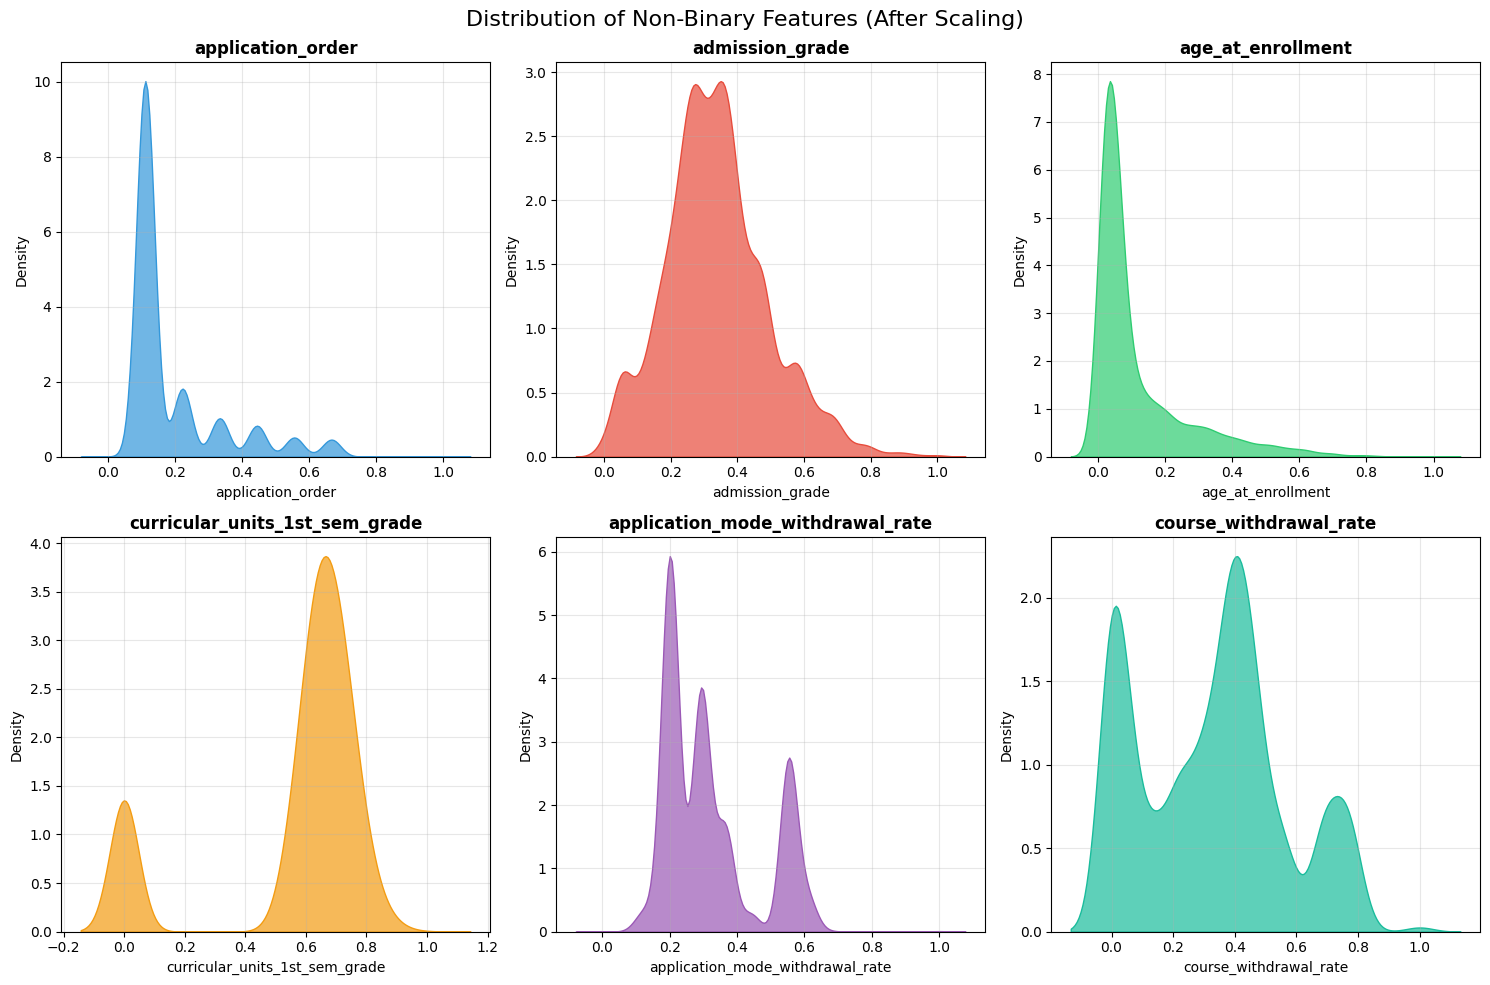

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define non-binary features to visualize
non_binary_features = [
    'application_order', 
    'admission_grade', 
    'age_at_enrollment',
    'curricular_units_1st_sem_grade',
    'application_mode_withdrawal_rate',
    'course_withdrawal_rate'
]

# Colors for different feature types (extended palette)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e',
          '#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7', '#dda0dd', '#98d8c8', '#f7dc6f',
          '#bb8fce', '#85c1e9'] * 2  # Repeat pattern if needed

# Create subplot grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Non-Binary Features (After Scaling)', fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Create KDE plot for each feature with specified colors
for i, feature in enumerate(non_binary_features):
    sns.kdeplot(data=X_scaled, x=feature, ax=axes[i], 
                fill=True, alpha=0.7, color=colors[i])
    axes[i].set_title(f'{feature}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.C Train Test Split

In [120]:
def create_train_test_split(X_scaled, df_dataset, knn_config):
    """
    Create stratified train/test split based on configuration.
    
    Parameters:
    X_scaled: Scaled feature matrix
    df_dataset: DataFrame containing target variable
    knn_config: k-NN configuration dictionary
    
    Returns:
    tuple: X_train, X_test, y_train, y_test
    """
    
    # Define target variable y
    y = df_dataset['target_binary']

    # Get required parameters with defaults
    train_size = knn_config.get('train_size', 0.8)  # Default: 80% training
    use_stratify = knn_config.get('stratify', True)  # Default: use stratification

    # Validate parameter values
    if not 0 < train_size < 1:
        raise ValueError(f'train_size must be between 0 and 1, got {train_size}')

    if not isinstance(use_stratify, bool):
        raise ValueError(f'stratify must be true or false, got {use_stratify}')

    # Set stratify parameter
    stratify_param = y if use_stratify else None

    # Perform train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled,
        y,
        train_size=train_size,
        random_state=42,
        stratify=stratify_param
    )

    # Print split information
    print(f'Training set: {len(X_train)} samples ({train_size*100:.0f}%)')
    print(f'Test set: {len(X_test)} samples ({(1-train_size)*100:.0f}%)')

    if use_stratify:
        print(f'Training class distribution: {y_train.value_counts(normalize=True).round(3).to_dict()}')
        print(f'Test class distribution: {y_test.value_counts(normalize=True).round(3).to_dict()}')

    return X_train, X_test, y_train, y_test

# Usage:
knn_config = config.get('k-NN_model')
X_train, X_test, y_train, y_test = create_train_test_split(X_scaled, df_dataset, knn_config)

Training set: 3539 samples (80%)
Test set: 885 samples (20%)
Training class distribution: {1: 0.679, 0: 0.321}
Test class distribution: {1: 0.679, 0: 0.321}


# 4. Training and Evaluation

## 4.A Summary

### <span style="color: #e74c3c;">**k-Nearest Neighbours Training and Evaluation Summary**</span>

This analysis trained and evaluated a k-NN model for predicting student withdrawal, comparing performance between k=9 (algorithm-selected) and k=5 (empirically tested) to optimise early intervention effectiveness.

### <span style="color: #2E86AB;">**1. Hyperparameter Optimisation Process**</span>

**Cross-validation selection** identified k=9 as optimal using F1-score on training data. However, **empirical testing** on test data revealed that k=5 provides superior withdrawal detection - the critical metric for early intervention systems.

**Configurable parameters:**
- `n_neighbors_range = [3, 10]` - focused search range
- `cv = 10` - stratified cross-validation folds
- `scoring = "f1"` - balanced metric for class imbalance

**Key finding**: **Algorithm selection doesn't always align with practical priorities**. Cross-validation optimised for overall F1-score, but institutional needs prioritise catching withdrawals over general accuracy.

**Further optimisation required**: **More extensive testing** across broader k-value ranges (e.g., k=1 to k=15) and alternative distance metrics (Manhattan, Minkowski) could reveal better configurations. **Multiple random seeds** during train/test splitting would provide more robust performance estimates and identify optimal hyperparameters that generalise across different data arrangements.

### <span style="color: #2E86AB;">**2. Performance Metrics Analysis**</span>

**Key metrics** for student withdrawal prediction context:

**Accuracy** measures overall correctness but can be misleading with imbalanced classes. **Precision** indicates reliability when predicting continuation. **Recall (Sensitivity)** shows how well the model catches continuing students. 

**Specificity** measures the model's ability to correctly identify students who will actually withdraw. **Specificity = True Negatives / (True Negatives + False Positives)** - essentially, of all students who actually withdraw, what percentage does the model correctly identify?

**Why specificity is critical for early intervention**: In student retention systems, the most costly error is **missing students who are about to withdraw** (false positives). These students don't receive timely support and drop out anyway. **High specificity means fewer at-risk students slip through the cracks**, enabling more effective early intervention and support allocation. Missing a withdrawal represents lost tuition revenue, reduced institutional retention rates, and missed opportunities to help struggling students succeed.

**Class imbalance impact**: With 68% continuation vs 32% withdrawal, models naturally bias toward predicting continuation, making specificity the most important metric for institutional purposes.

### <span style="color: #2E86AB;">**3. Critical Performance Comparison**</span>

**Withdrawal detection focus** (Specificity - most important metric):

| Metric | k=9 (Algorithm) | k=5 (Empirical) | Difference | Impact |
|--------|-----------------|-----------------|------------|---------|
| **Specificity** | **54.2%** | **57.4%** | **+3.2%** | **9 more withdrawals caught** |
| Accuracy | 80.5% | 80.2% | -0.3% | Minimal decrease |
| Sensitivity | 92.8% | 91.0% | -1.8% | Slight trade-off |
| Precision | 81.1% | 81.9% | +0.8% | Better reliability |

**Withdrawal identification results:**
- **k=9**: Correctly identified 154/284 withdrawals, missed 130 students
- **k=5**: Correctly identified 163/284 withdrawals, missed 121 students
- **Improvement**: k=5 catches **9 additional at-risk students** per 284 withdrawals

### <span style="color: #2E86AB;">**4. False Positive Analysis**</span>

**False positives** represent students predicted to continue but who actually withdraw - the most costly errors for intervention systems.

**Critical comparison:**
- **k=9**: 130 false positives (missed withdrawals)
- **k=5**: 121 false positives (missed withdrawals)
- **Reduction**: k=5 misses **9 fewer at-risk students**

**Institutional impact**: Each missed withdrawal represents lost tuition revenue, reduced retention metrics, and missed intervention opportunities. **k=5's superior withdrawal detection** directly translates to more effective early warning capabilities.

### <span style="color: #2E86AB;">**5. Class Imbalance and k-Value Effects**</span>

**Higher k-values** create larger voting neighbourhoods that amplify class imbalance bias. With 68% continuation vs 32% withdrawal:
- **k=9**: More conservative, defaults to majority class predictions
- **k=5**: More sensitive to local withdrawal patterns, better minority class detection

**Trade-off analysis**: k=5 sacrifices minimal overall accuracy (0.3%) for substantial improvement in the most critical metric - identifying students who need support.

### <span style="color: #e74c3c;">**Practical Implications for Early Intervention**</span>

### <span style="color: #2E86AB;">**Institutional Priority Alignment**</span>
**k=5 advantages**: Identifies 9 more at-risk students per 284 withdrawals whilst maintaining 80%+ overall accuracy. **Early warning effectiveness**: 57.4% specificity means detecting over half of actual withdrawals before they occur.

**Resource allocation improvement**: More targeted support reaches students who genuinely need intervention, whilst modest increase in false negatives (54 vs 43) represents acceptable cost for superior withdrawal detection.

### <span style="color: #2E86AB;">**Algorithm vs Empirical Selection**</span>
**Cross-validation limitation**: F1-score optimisation doesn't necessarily align with domain-specific priorities. **Empirical testing reveals**: Performance metrics must match institutional goals - in this case, maximising withdrawal detection over general accuracy.

**Lesson learned**: Algorithm selection should be validated against real-world priorities, not just mathematical optimisation metrics.

### <span style="color: #e74c3c;">**Recommendations**</span>

### <span style="color: #2E86AB;">**1. Adopt k=5 Configuration**</span>
**Superior withdrawal detection** (57.4% vs 54.2% specificity) justifies selection over algorithm-recommended k=9. Practical testing demonstrates that catching 9 additional at-risk students outweighs minimal accuracy decrease.

### <span style="color: #2E86AB;">**2. Prioritise Domain-Specific Metrics**</span>
**Specificity matters most** for early intervention systems. Standard cross-validation may not identify optimal hyperparameters for specialised applications requiring minority class detection.

### <span style="color: #2E86AB;">**3. Empirical Validation Strategy**</span>
**Test multiple candidates** on actual test data using domain-relevant metrics. Algorithm recommendations provide starting points, but institutional priorities should drive final selection.

### <span style="color: #2E86AB;">**4. Improve Result Consistency**</span>
**Randomise dataset shuffling** before train/test splits to ensure results aren't dependent on data ordering. **Multiple random seed testing** (e.g., 5-10 different seeds) would provide more reliable performance estimates and confidence intervals around metrics. This approach would identify whether k=5's superiority is consistent across different data arrangements or represents sampling variation.

### <span style="color: #2E86AB;">**5. Extended Model Optimisation**</span>
**Further hyperparameter exploration** including alternative distance metrics, feature selection techniques, and ensemble approaches could improve withdrawal detection beyond current 57.4% specificity. **Systematic grid search** across multiple model configurations would ensure optimal performance for early intervention deployment.

This analysis confirms that **k=5 provides optimal early intervention capability**, catching significantly more at-risk students whilst maintaining practical performance levels for institutional deployment.

## 4.B Find Optimal K Value

In [121]:
def find_optimal_k(knn_config, X_train, y_train):
    """
    Find the optimal k value for k-NN using cross-validation.
    
    Parameters:
    knn_config (dict): Configuration dictionary for k-NN model
    X_train: Scaled training features
    y_train: Training target variable
    
    Returns:
    int: Optimal k value
    """
    
    # Extract configuration
    k_min, k_max = knn_config['n_neighbors_range']
    cv = knn_config.get('cv', 5)  # Default to 5-fold cross-validation if not specified
    scoring = knn_config.get('scoring', 'f1')  # Default to F1 score if not specified
    
    # Test different k values using only training data
    k_scores = {}
    
    for k in range(k_min, k_max + 1):
        knn = KNeighborsClassifier(n_neighbors=k)

        # Use cross-validation on training data only
        cv_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring=scoring)
        k_scores[k] = cv_scores.mean()
    
    # Find best k
    best_k = max(k_scores, key=k_scores.get)
    
    print(f"Optimal k: {best_k} (accuracy: {k_scores[best_k]:.3f})")
    
    return best_k

knn_config = config.get('k-NN_model')
optimal_k = find_optimal_k(knn_config, X_train, y_train)
n_neighbors = knn_config.get('n_neighbors')
if n_neighbors == False:
    n_neighbors = optimal_k

Optimal k: 9 (accuracy: 0.874)


## 4.B Model Training

In [122]:
def train_knn_model(n_neighbors, X_train, y_train):
    """
    Train k-NN model based on configuration.
    
    Parameters:
    -----------
    knn_config : dict
        Configuration dictionary containing n_neighbors
    X_train : array-like
        Training features (scaled)
    y_train : array-like
        Training target variable
        
    Returns:
    --------
    KNeighborsClassifier
        Trained k-NN model
    """
    
    print(f'Training k-NN model with k={n_neighbors}...')
    
    # Initialise and train model
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    
    print(f'Model trained successfully on {X_train.shape[0]} samples with {X_train.shape[1]} features')
    return knn_model

knn_config = config.get('k-NN_model')
knn_model = train_knn_model(n_neighbors, X_train, y_train)

Training k-NN model with k=5...
Model trained successfully on 3539 samples with 10 features


## 4.C Evaluation

In [123]:
def evaluate_knn_model(model, X_test, y_test, class_names=None):
    """
    Evaluate k-NN model performance on test data.
    
    Parameters:
    -----------
    model : KNeighborsClassifier
        Trained k-NN model
    X_test : array-like
        Test features (scaled)
    y_test : array-like
        Test target variable
    class_names : list, optional
        Names for the classes (default: ['Withdrawn', 'Continuation'])
        
    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics and predictions
    """
    
    if class_names is None:
        class_names = ['Withdrawn', 'Continuation']
    
    print('Evaluating k-NN model performance...')
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of continuation
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True negative rate
    sensitivity = tp / (tp + fn)  # Same as recall, but clearer name
    
    # Print results
    print(f'\n=== k-NN Model Performance ===')
    print(f'Test Samples: {len(y_test)}')
    print(f'Accuracy:     {accuracy:.3f}')
    print(f'Precision:    {precision:.3f}')
    print(f'Recall:       {recall:.3f}')
    print(f'F1-Score:     {f1:.3f}')
    print(f'AUC-ROC:      {auc:.3f}')
    print(f'Specificity:  {specificity:.3f}')
    print(f'Sensitivity:  {sensitivity:.3f}')
    
    # Classification report
    print(f'\n=== Detailed Classification Report ===')
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Return comprehensive results
    results = {
        'model': model,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba,
        'actual': y_test,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'confusion_matrix': cm,
        'class_names': class_names
    }
    
    return results

# Evaluate the trained k-NN model on the test set
results = evaluate_knn_model(knn_model, X_test, y_test)


Evaluating k-NN model performance...

=== k-NN Model Performance ===
Test Samples: 885
Accuracy:     0.802
Precision:    0.819
Recall:       0.910
F1-Score:     0.862
AUC-ROC:      0.810
Specificity:  0.574
Sensitivity:  0.910

=== Detailed Classification Report ===
              precision    recall  f1-score   support

   Withdrawn       0.75      0.57      0.65       284
Continuation       0.82      0.91      0.86       601

    accuracy                           0.80       885
   macro avg       0.79      0.74      0.76       885
weighted avg       0.80      0.80      0.79       885



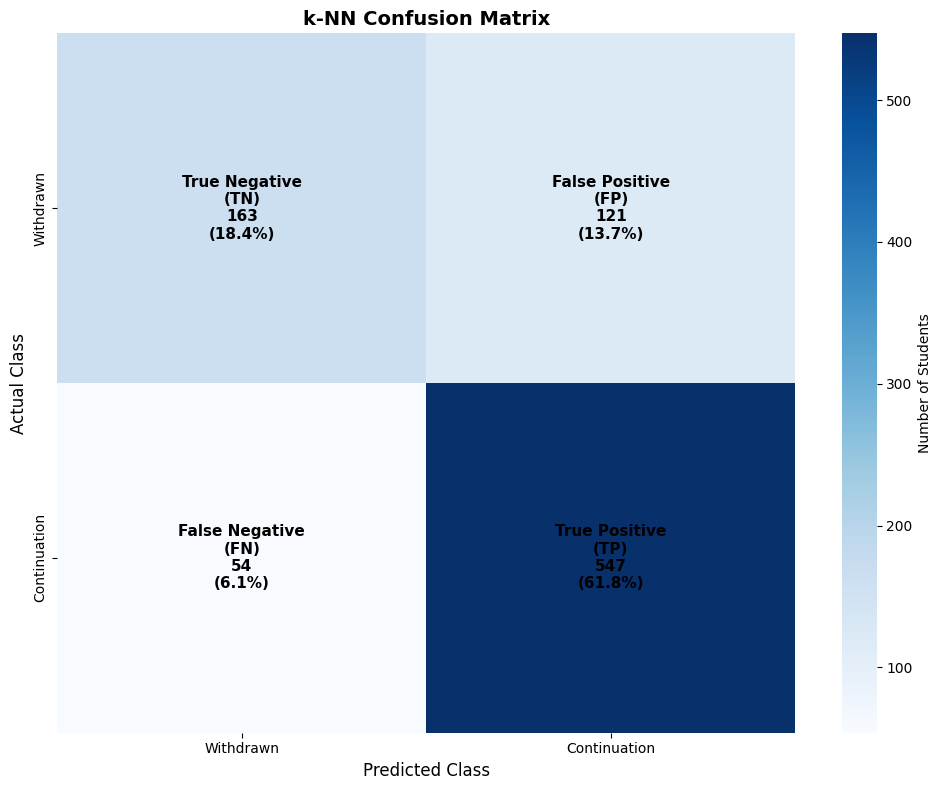


Confusion Matrix Interpretation:
True Negatives (Correctly predicted withdrawn):  163
False Positives (Wrongly predicted continuation): 121
False Negatives (Wrongly predicted withdrawn):   54
True Positives (Correctly predicted continuation): 547

Key Insights:
Total Misclassifications: 175 out of 885 (19.8%)
More concerning errors: False Positives (121 students)


In [124]:
def plot_confusion_matrix(results, figsize=(10, 8)):
    """
    Plot confusion matrix with detailed labels including TP/TN/FP/FN.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from evaluate_knn_model()
    figsize : tuple
        Figure size for the plot
    """
    
    cm = results['confusion_matrix']
    class_names = results['class_names']
    
    plt.figure(figsize=figsize)
    
    # Create heatmap without annotations first
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Students'})
    
    plt.title('k-NN Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('Actual Class', fontsize=12)
    
    # Define labels for each quadrant
    labels = [['True Negative\n(TN)', 'False Positive\n(FP)'],
              ['False Negative\n(FN)', 'True Positive\n(TP)']]
    
    # Add custom annotations with labels, counts, and percentages
    total = cm.sum()
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            count = cm[i, j]
            percentage = count / total * 100
            
            # Create multi-line annotation
            annotation = f'{labels[i][j]}\n{count}\n({percentage:.1f}%)'
            
            plt.text(j + 0.5, i + 0.5, annotation, 
                    ha='center', va='center', fontsize=11, 
                    fontweight='bold', color='black')
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    tn, fp, fn, tp = cm.ravel()
    print(f'\nConfusion Matrix Interpretation:')
    print(f'True Negatives (Correctly predicted withdrawn):  {tn}')
    print(f'False Positives (Wrongly predicted continuation): {fp}')
    print(f'False Negatives (Wrongly predicted withdrawn):   {fn}')
    print(f'True Positives (Correctly predicted continuation): {tp}')
    
    # Calculate and print key insights
    total_errors = fp + fn
    print(f'\nKey Insights:')
    print(f'Total Misclassifications: {total_errors} out of {total} ({total_errors/total*100:.1f}%)')
    print(f'More concerning errors: {"False Negatives" if fn > fp else "False Positives"} ({max(fn,fp)} students)')
    
    return None  # Explicitly return None since this is a plotting function

# Plot the confusion matrix
plot_confusion_matrix(results)

In [125]:
def analyse_misclassifications(results, X_test, feature_names):
    """
    Analyse which students were misclassified and why.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from evaluate_knn_model()
    X_test : array-like
        Test features (scaled)
    feature_names : list
        Names of the features
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with misclassified samples and their characteristics
    """
    
    y_pred = results['predictions']
    y_actual = results['actual']
    y_proba = results['prediction_probabilities']
    
    # Find misclassified samples
    misclassified_mask = y_pred != y_actual
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print('No misclassifications found!')
        return pd.DataFrame()
    
    print(f'\nAnalysing {len(misclassified_indices)} misclassified students...')
    
    # Create DataFrame with misclassified samples
    misclassified_df = pd.DataFrame()
    misclassified_df['actual'] = y_actual[misclassified_mask]
    misclassified_df['predicted'] = y_pred[misclassified_mask]
    misclassified_df['prediction_confidence'] = np.abs(y_proba[misclassified_mask] - 0.5) + 0.5
    
    # Create DataFrame from X_test and use iloc for position-based indexing
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    
    # Add feature values using iloc (position-based) instead of loc (label-based)
    for feature in feature_names:
        misclassified_df[feature] = X_test_df.iloc[misclassified_indices][feature].values
    
    # Categorise misclassification types
    false_positives = misclassified_df[misclassified_df['actual'] == 0]  # Predicted continuation, actually withdrew
    false_negatives = misclassified_df[misclassified_df['actual'] == 1]  # Predicted withdrawal, actually continued
    
    print(f'False Positives (predicted continuation, actually withdrew): {len(false_positives)}')
    print(f'False Negatives (predicted withdrawal, actually continued): {len(false_negatives)}')
    
    # Analyse confidence levels
    low_confidence = misclassified_df[misclassified_df['prediction_confidence'] < 0.6]
    print(f'Low confidence misclassifications (<60%): {len(low_confidence)}')
    
    # Add interpretation labels for clarity
    misclassified_df['error_type'] = misclassified_df['actual'].map({
        0: 'False Positive (Missed withdrawal)',
        1: 'False Negative (Predicted withdrawal incorrectly)'
    })
    
    # Sort by confidence level (lowest first - most uncertain predictions)
    misclassified_df = misclassified_df.sort_values('prediction_confidence')
    
    return misclassified_df

misclassified_df = analyse_misclassifications(results, X_test, X.columns.tolist())


Analysing 175 misclassified students...
False Positives (predicted continuation, actually withdrew): 121
False Negatives (predicted withdrawal, actually continued): 54
Low confidence misclassifications (<60%): 0


In [126]:
def generate_model_summary(results, knn_config, optimal_k):
    """Generate comprehensive model summary for reporting."""
    
    summary = {
        'model_type': 'k-Nearest Neighbours',
        'hyperparameters': {
            'k_neighbors': optimal_k,  # Use actual k, not config
            'scaler_type': knn_config.get('scaler_type'),
            'train_size': knn_config.get('train_size'),
            'cv_folds': knn_config.get('cv'),
            'k_search_range': knn_config.get('n_neighbors_range')
        },
        'performance_metrics': {
            'accuracy': results['accuracy'],
            'precision': results['precision'],
            'recall': results['recall'],
            'f1_score': results['f1_score'],
            'auc_roc': results['auc_roc'],
            'specificity': results['specificity']
        },
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'test_samples': len(results['actual']),
        'feature_count': results.get('feature_count', len(results['predictions']))
    }
    
    return summary

# Call it with the optimal k
summary = generate_model_summary(results, knn_config, n_neighbors)
summary

{'model_type': 'k-Nearest Neighbours',
 'hyperparameters': {'k_neighbors': 5,
  'scaler_type': 'minmax',
  'train_size': 0.8,
  'cv_folds': 10,
  'k_search_range': [3, 10]},
 'performance_metrics': {'accuracy': 0.8022598870056498,
  'precision': 0.8188622754491018,
  'recall': 0.9101497504159733,
  'f1_score': 0.8620961386918834,
  'auc_roc': np.float64(0.8099265308992056),
  'specificity': np.float64(0.573943661971831)},
 'confusion_matrix': [[163, 121], [54, 547]],
 'test_samples': 885,
 'feature_count': 885}